# Rationale

Purpose of this notebook is to create fake user data for our experiment which we have not yet run. This way, we have something to analyze during the course.

## Load all the data

After loading a few packages, we list all csv's in the trial material folder, load them and combine them into a single data frame.

In [1]:
library("gamlss.dist") #NOTE load order is important for dplyr::select to be loaded last!
library("tidyverse")

Loading required package: MASS
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


In [2]:
# read all data into one data frame
setwd("./trial_materials_ef/")
file_list = list.files(".", pattern="Subject")
dat = bind_rows(lapply(file_list, read_csv))
setwd("..")

Parsed with column specification:
cols(
  Subject = col_character(),
  Trial = col_character(),
  Direction = col_integer(),
  Congruency = col_integer(),
  StimulusMap = col_integer(),
  Stimulus = col_character(),
  Flanker = col_character(),
  CorrectAnswer = col_character()
)
Parsed with column specification:
cols(
  Subject = col_character(),
  Trial = col_character(),
  Direction = col_integer(),
  Congruency = col_integer(),
  StimulusMap = col_integer(),
  Stimulus = col_character(),
  Flanker = col_character(),
  CorrectAnswer = col_character()
)
Parsed with column specification:
cols(
  Subject = col_character(),
  Trial = col_character(),
  Direction = col_integer(),
  Congruency = col_integer(),
  StimulusMap = col_integer(),
  Stimulus = col_character(),
  Flanker = col_character(),
  CorrectAnswer = col_character()
)
Parsed with column specification:
cols(
  Subject = col_character(),
  Trial = col_character(),
  Direction = col_integer(),
  Congruency = col_integer(),
  

In [3]:
str(dat)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	96 obs. of  8 variables:
 $ Subject      : chr  "01" "01" "01" "01" ...
 $ Trial        : chr  "01" "02" "03" "04" ...
 $ Direction    : int  0 1 0 1 0 1 0 1 0 1 ...
 $ Congruency   : int  0 1 2 0 1 2 0 1 2 0 ...
 $ StimulusMap  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Stimulus     : chr  "Z" "B" "Z" "B" ...
 $ Flanker      : chr  "Z" "Z" "G" "B" ...
 $ CorrectAnswer: chr  "s" "l" "s" "l" ...


## Creating the fake data

We will create the fake data with the reverse procedure by which we analyze them: By adding different effects and noise. That way, we can check our model results against the 'reality' during creation.

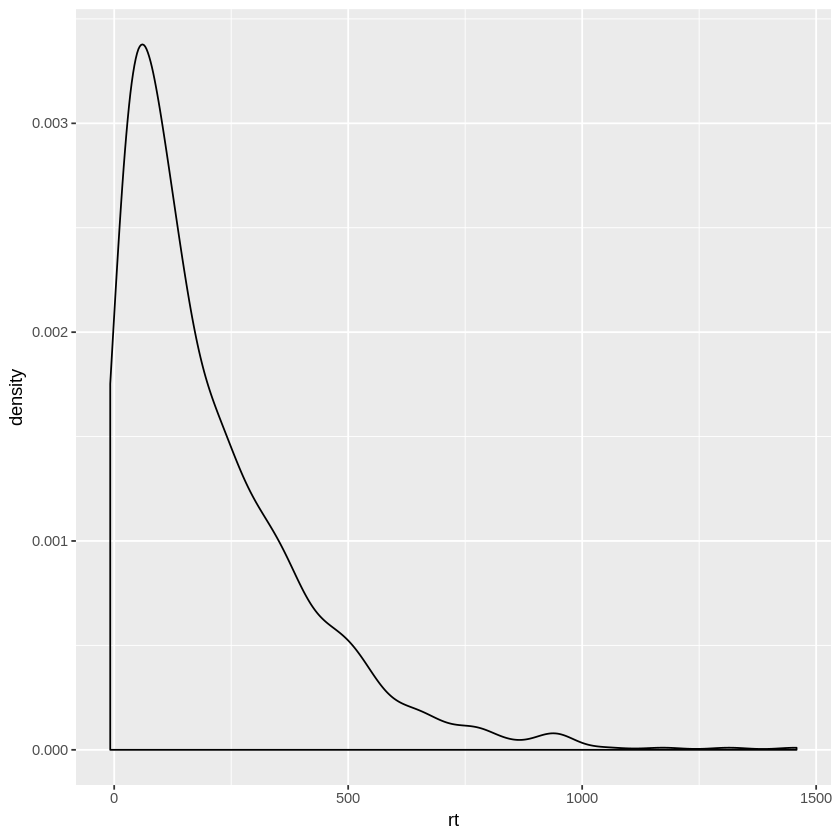

In [4]:
data.frame(rt=rexGAUS(1000, mu = 0, sigma = 6, nu = 200)) %>%
ggplot(aes(x=rt)) + geom_density()

In [20]:
subject_intercepts = rnorm(max(as.numeric(dat$Subject)), mean=0, sd=10)

dat %>% mutate(
    sub = as.numeric(Subject),
    intercept = 500,
    dir_effect = ifelse(Direction==0, 10, -10), # right is faster than left
    cong_effect = ifelse(Congruency==0, -45, ifelse(Congruency==1, 45, 0)),
    subj_effects = subject_intercepts[sub],
    noise = rexGAUS(nrow(dat), mu = 0, sigma = 4, nu = 100),
    rt = as.integer(intercept + dir_effect + cong_effect + subj_effects + noise),
    Direction = ifelse(Direction==0, "left", "right"),
    Congruency = ifelse(Congruency==0, "congruent", ifelse(Congruency==1, "incongruent", "neutral")),
    Trial = as.numeric(Trial)
) %>% select(c('Subject', 'Trial', 'Direction', 'Congruency', 'Stimulus', 'CorrectAnswer', 'rt')) -> dat_rts

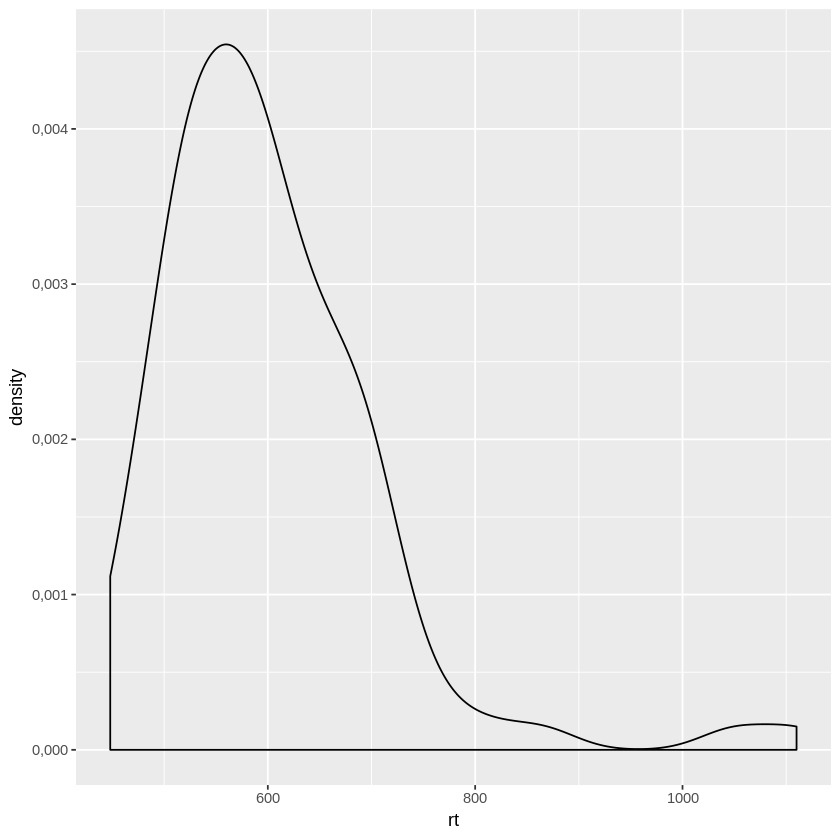

In [21]:
dat_rts %>%
ggplot(aes(x=rt)) + 
    geom_density(alpha=.3)

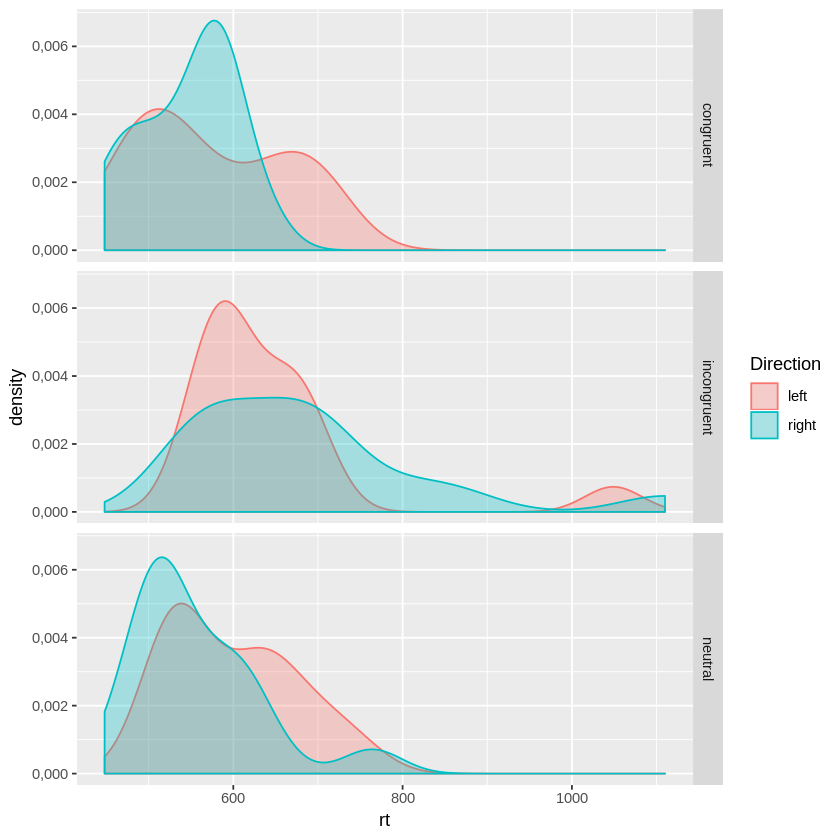

In [47]:
dat_rts %>%
ggplot(aes(x=rt, colour=Direction, fill=Direction)) + 
    geom_density(alpha=.3) + 
    facet_grid(Congruency ~ .) 

In [23]:
write_csv(dat_rts, 'fake_results.csv')

In [54]:
setwd("..")

In [55]:
setwd("./results/")
for (subject in unique(dat_rts$Subject)) {
    dat_rts %>% filter(Subject==subject) %>% select(-c(is_outlier, rt_c)) %>%
    write_csv(sprintf('%s.csv', subject))
    }
setwd("..")

# Double check modeling

This double-checks if we get the same result with R as we get with statsmodels. It seems to work fine.

In [46]:
library(lme4)

iqr = IQR(dat_rts$rt)
quartiles = quantile(dat_rts$rt, c(.25, .75))
fences = c(quartiles[1] - 1.5 * iqr,quartiles[2] + 1.5 * iqr)

dat_rts %>% mutate(is_outlier = rt < fences[1] | rt > fences[2],
                rt_c = scale(rt, center=TRUE, scale=FALSE)) -> dat_rts

dat_rts$Congruency = factor(dat_rts$Congruency)
contrasts(dat_rts$Congruency) = contr.treatment(3)
contrasts(dat_rts$Congruency)

m1 = lmer(rt ~ Congruency + Direction + (1|Subject), subset(dat_rts, is_outlier==FALSE))
summary(m1)

m2 = lmer(rt ~ Congruency * Direction + (1|Subject), subset(dat_rts, is_outlier==FALSE))
summary(m2)

anova(m1, m2)

2 3
congruent   0 0
incongruent 1 0
neutral     0 1

Warning message in printCoefmat(x$coefficients, digits = digits, signif.stars = signif.stars):
“NAs introduced by coercion”

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ Congruency + Direction + (1 | Subject)
   Data: subset(dat_rts, is_outlier == FALSE)

REML criterion at convergence: 1008,5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1,5271 -0,8055 -0,1174  0,6321  2,5904 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept)  332,3   18,23   
 Residual             4544,2   67,41   
Number of obs: 92, groups:  Subject, 8

Fixed effects:
               Estimate Std. Error t value
(Intercept)      572,14      15,27  37,478
Congruency2       64,09      17,48   3,667
Congruency3       16,62      16,85   0,986
Directionright   -21,28      14,07  -1,512

Correlation of Fixed Effects:
            (Intr) Cngrn2 Cngrn3
Congruency2 -0,546              
Congruency3 -0,552  0,482       
Directnrght -0,461  0,029  0,000

Warning message in printCoefmat(x$coefficients, digits = digits, signif.stars = signif.stars):
“NAs introduced by coercion”

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ Congruency * Direction + (1 | Subject)
   Data: subset(dat_rts, is_outlier == FALSE)

REML criterion at convergence: 988,2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1,5226 -0,7492 -0,1217  0,7064  2,7570 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept)  351,9   18,76   
 Residual             4492,4   67,03   
Number of obs: 92, groups:  Subject, 8

Fixed effects:
                           Estimate Std. Error t value
(Intercept)                  576,13      18,02  31,969
Congruency2                   44,25      24,10   1,836
Congruency3                   23,56      23,70   0,994
Directionright               -29,25      23,70  -1,234
Congruency2:Directionright    42,35      34,76   1,218
Congruency3:Directionright   -13,88      33,51  -0,414

Correlation of Fixed Effects:
            (Intr) Cngrn2 Cngrn3 Drctnr Cng2:D
Congruency2 -0,646                            
Congruency3 -0,6

refitting model(s) with ML (instead of REML)


Df AIC      BIC      logLik    deviance Chisq    Chi Df Pr(>Chisq)
m1 6  1048,624 1063,755 -518,3122 1036,624       NA NA            NA 
m2 8  1049,727 1069,902 -516,8637 1033,727 2,896891  2     0,2349352